In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

## Dataset choice

For my experiments on Lazy Classification, I chose the loan-approval-classification-data dataset because it represents a real-world problem that many individuals and organizations face. Loan approval processes are critical in the financial sector, influencing both the decisions of lenders and the financial futures of applicants.

In [3]:
data = pd.read_csv('/kaggle/input/loan-approval-classification-data/loan_data.csv')

In [4]:
print('Shape of the data:', data.shape)
data.info()

Shape of the data: (45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  p

In [5]:
# Explore duplicates
data.duplicated().sum()

0

In [6]:
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


This correlation matrix shows that loan status have rather strong correlation with loan int rate and loan percent income

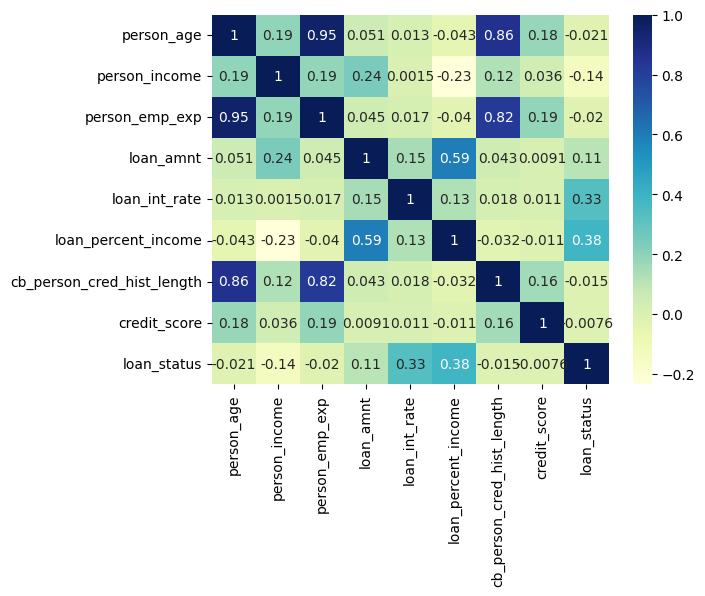

In [8]:
# Plotting correlation heatmap
dataplot = sns.heatmap(data.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

In [9]:
y = data['loan_status']
X = data.drop(columns=['loan_status'])
# As data is very big, let's take 10% stratifying by target
X, _, y, _ = train_test_split(X, y, test_size=0.95, stratify=y, random_state=42)

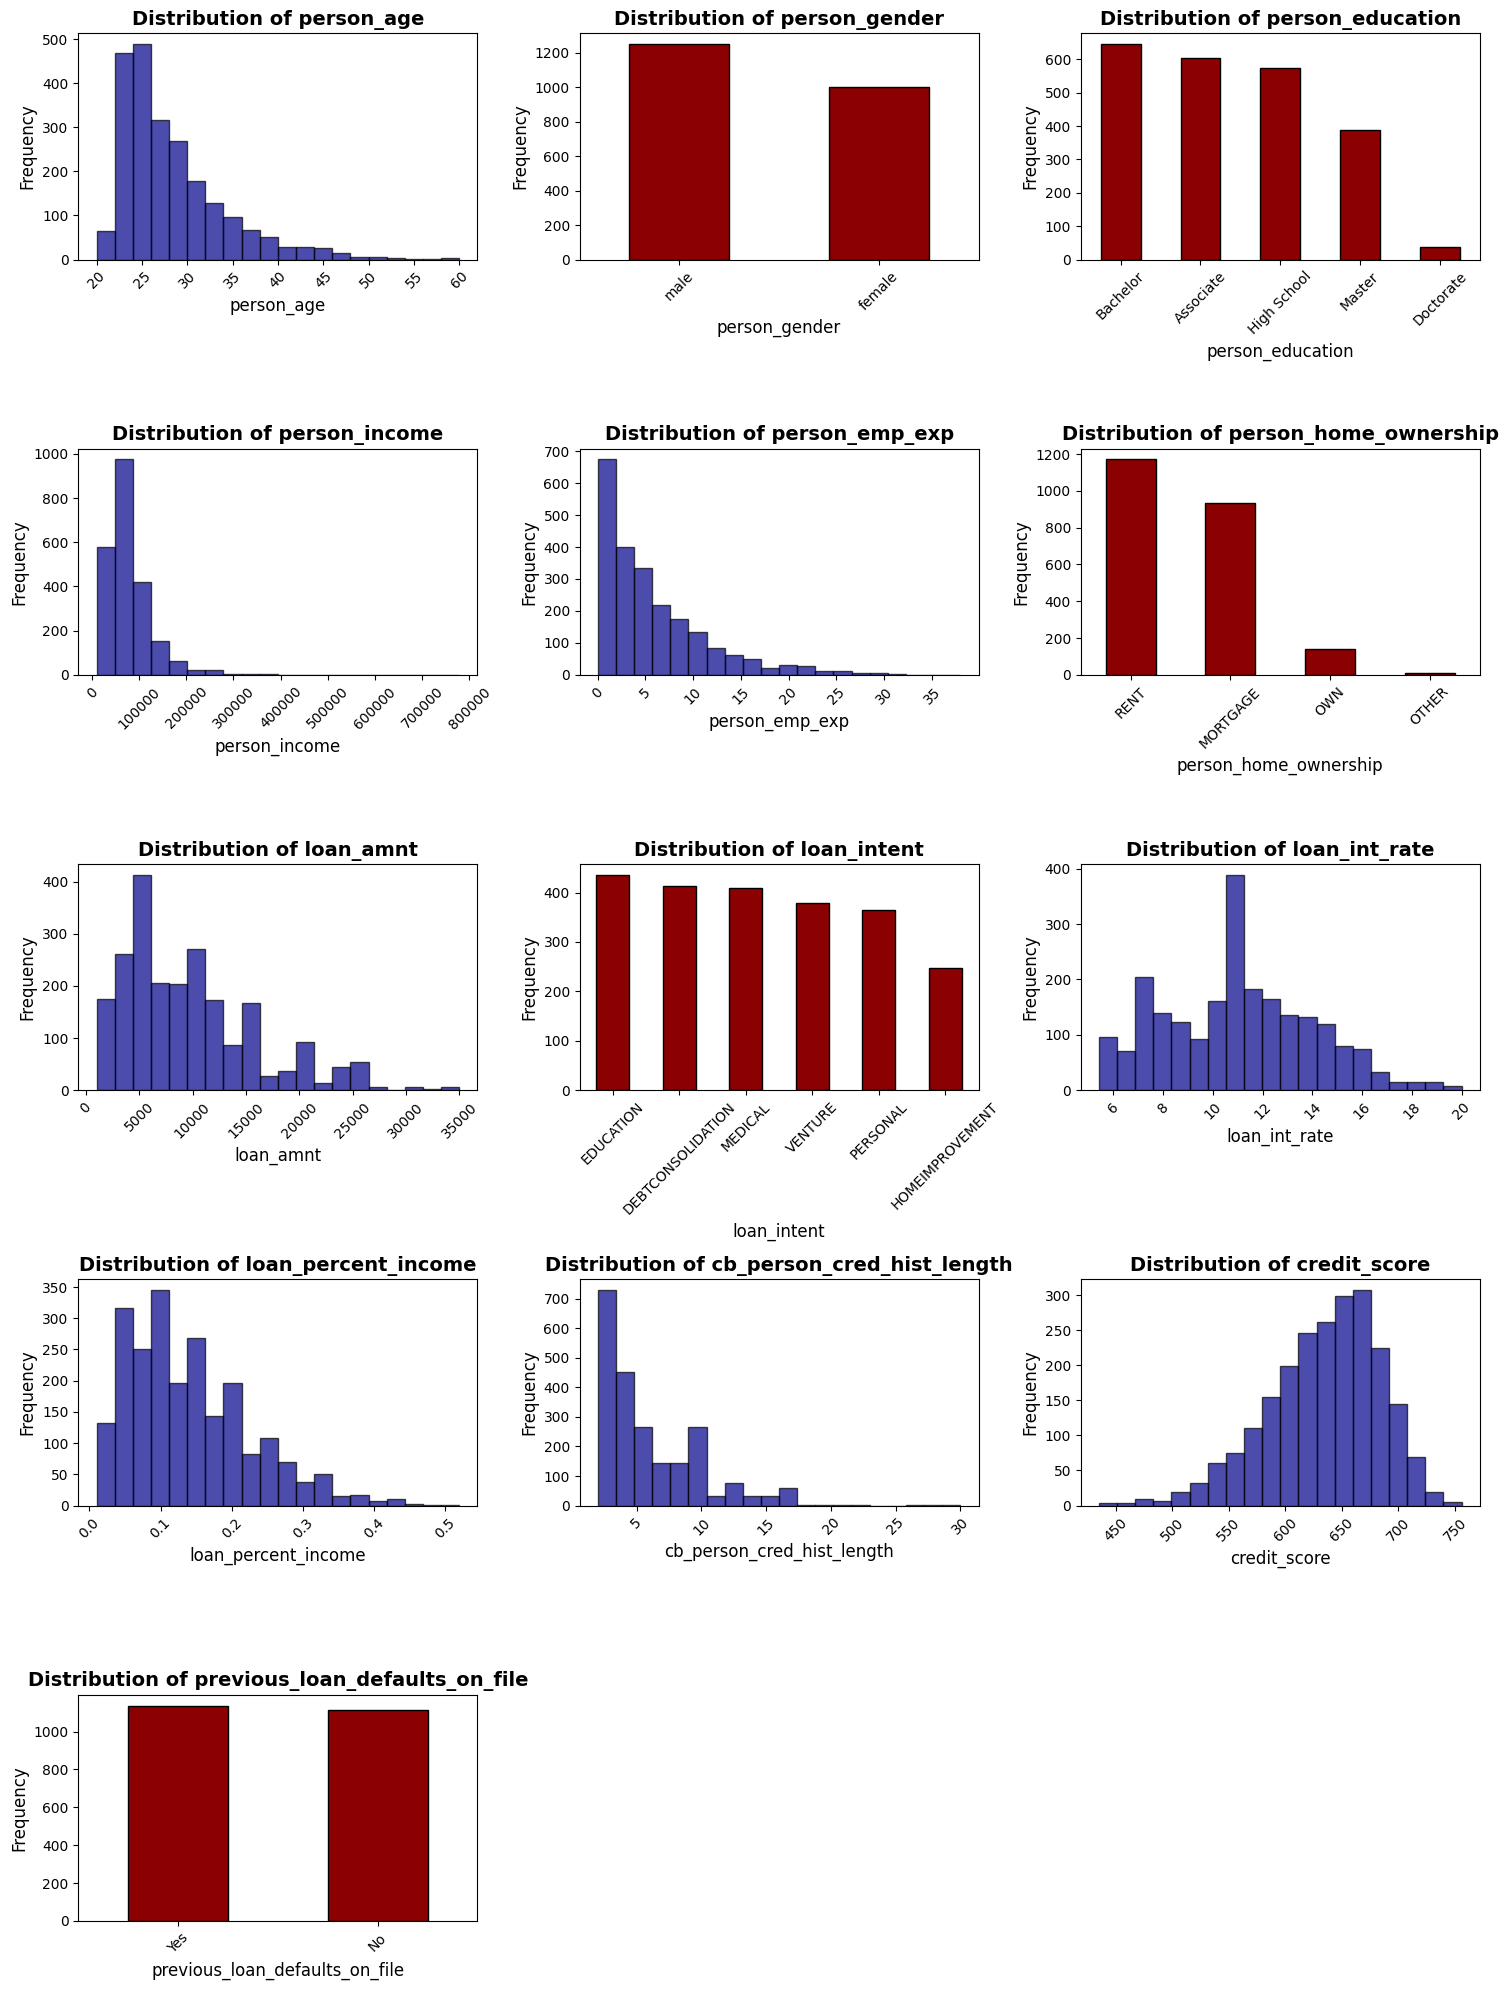

In [43]:
num_columns = len(X.columns)
cols = 3
rows = math.ceil(num_columns / cols)

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, column in enumerate(X.columns):
    ax = axes[i]
    if X[column].dtype == 'object' or len(X[column].unique()) < 20:
        # For categorical or discrete features, use a bar plot
        X[column].value_counts().plot(kind='bar', ax=ax, color='darkred', edgecolor='black')
        ax.set_title(f'Distribution of {column}', fontsize=14, fontweight='bold')
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
    else:
        # For continuous features, use a histogram
        X[column].plot(kind='hist', bins=20, ax=ax, color='darkblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {column}', fontsize=14, fontweight='bold')
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

    # Rotate x-axis labels
    ax.xaxis.set_tick_params(rotation=45)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for readability
plt.savefig('your_plot.png')  # Save the figure as a PNG file
plt.show()

In [44]:
X_numeric = X[['person_age', 'person_income','person_emp_exp', 'loan_amnt', 'loan_int_rate',
               'loan_percent_income', 'cb_person_cred_hist_length','credit_score']]

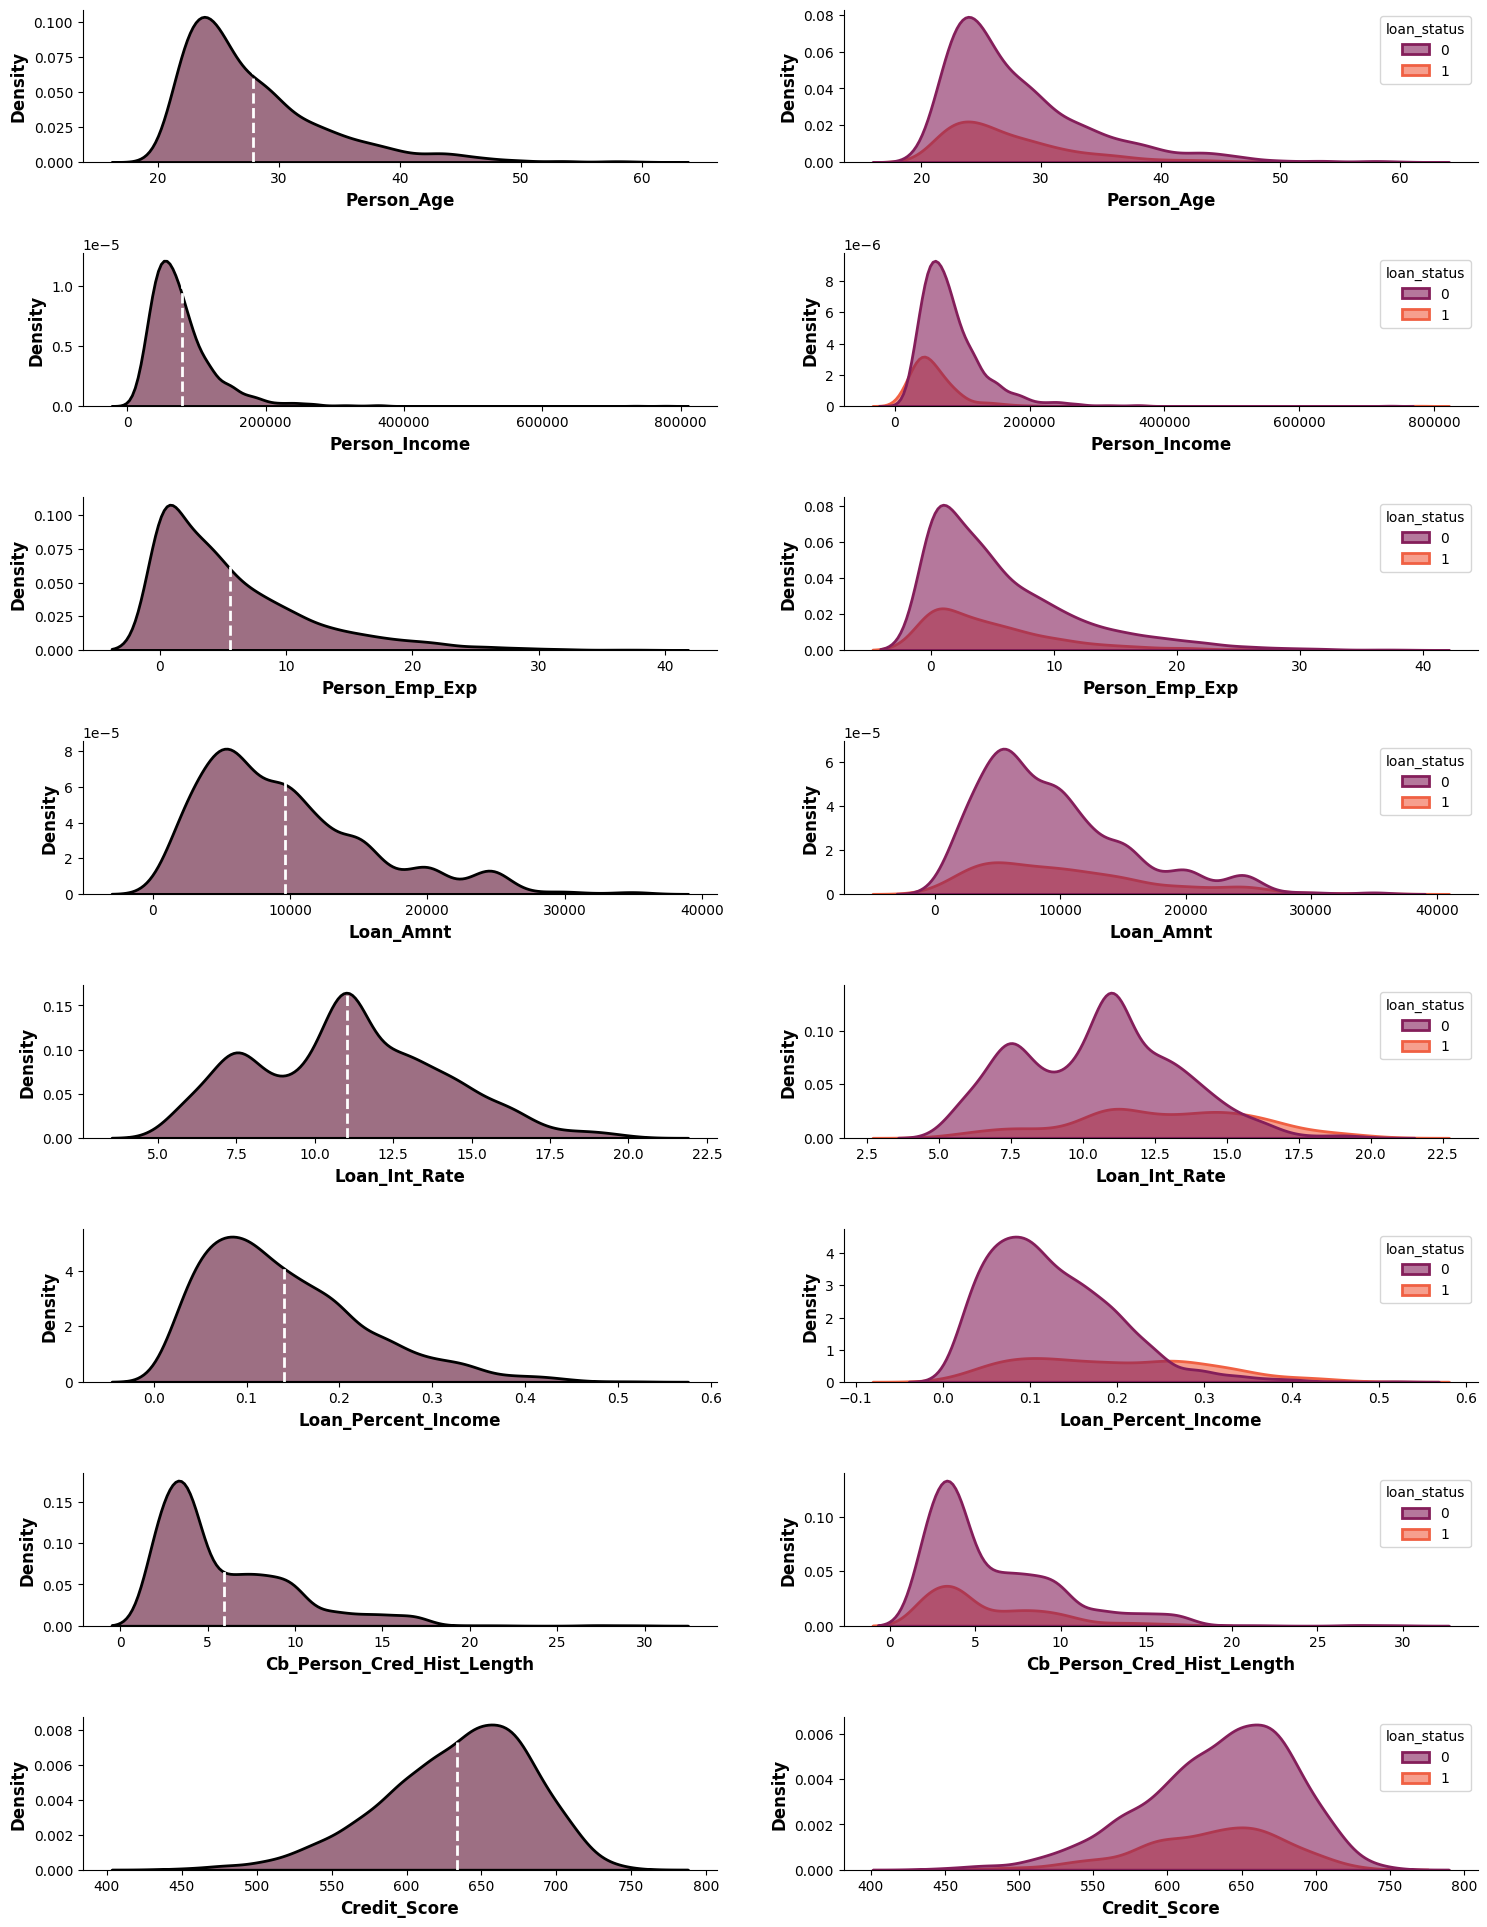

In [45]:
plotIndex = 1
plt.figure(figsize=(18,40))
for i in range(len(X_numeric.columns)):
    plt.subplot(len(X.columns), 2, plotIndex)
    sns.kdeplot(data=X_numeric, x=X_numeric.columns[i], 
                fill=True, linewidth=2, color='#5c1031', alpha=0.6, edgecolor='k')
    plt.axvline(X_numeric[X_numeric.columns[i]].mean(), color='white', linestyle='--', linewidth=2)
    plt.xlabel(xlabel=X_numeric.columns[i].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    plt.subplot(len(X.columns), 2, plotIndex+1)
    sns.kdeplot(data=X_numeric, x=X_numeric.columns[i], 
                fill=True, hue=y, linewidth=2, palette='rocket', alpha=0.6)
    plt.xlabel(xlabel=X_numeric.columns[i].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
    plotIndex += 2
plt.subplots_adjust(hspace=0.6)
plt.savefig('data_distribution.png')
plt.show()

## Data serialization

Explanation of serialization choice:
1. **person_age**: Discretization Encoding: Transform age into meaningful age groups, as certain age ranges could influence loan approval probability. Meaningful age groups:
    * <=22: Borrowers in this group are often students or just entering the workforce. They may not have an established credit history or significant income, making them higher risk for lenders.
    * \>22 & <=28: This age group typically includes recent graduates and young professionals who may still be establishing their financial credibility.
    * \>28 & <=35: Here, borrowers are likely to have more secure employment and possibly increased financial responsibilities
    * \>35 & <=45: Borrowers in this range are generally more settled in their careers
    * \>45 & <=55: Individuals in this age group often have greater financial stability and experience
    * \>55 & <=65: Borrowers approaching retirement may display more conservative financial behavior as they focus on savings
    * \>65 & <=75: Seniors in this age demographic are often relying on fixed incomes, such as pensions or social security
    * \>75: Individuals over 75 may have unique financial situations
2. **person_gender**: One-hot Encoding: Create separate binary columns for 'male' and 'female'
3. **person_education**: Create individual binary columns for each education level. Education level can determine income potential and stability, influencing loan approval decisions
4. **person_income**: Discretization Encoding: Group into ranges based on income levels:
    * <=30,000 (low income)
    * \>30,000 & <=60,000 (middle income)
    * \>60,000 & <=100,000 (upper middle income)
    * \>100,000 (high income)
5. **person_emp_exp**:
    * <1 year (Interns)
    * \>1 & <=3 (Novice specialists)
    * \>3 & <=7 (Middle specialists)
    * \>7 & <=15 (Seniors)
    * \>15 & <=25 (Professionals)
    * \>25 (Masters)
6. **person_home_ownership**: One-hot Encoding: Home ownership status may influence perceived borrower risk and financial stability.
7. **loan_amnt**: Discretization Encoding: Classify loan amounts for better risk assessment:
    * <2500 (Very small loans)
    * \>2500 & <=5000 (Small loans)
    * \>5000 & <=10000 (Middle loans)
    * \>10000 & <=15000 (Upper Middle loans)
    * \>15000 & <=25000 (Large loans)
    * \>25000 (Very Large loans)
8. **loan_intent**: One-hot Encoding: The intent can impact perceived risk.
10. **loan_int_rate**: Discretization Encoding: Create groups based on interest rate levels:
    * <7 (small interest rate)
    * \>7 & <=11 (lower middle interest rate)
    * \>11 & <=15 (upper middle interest rate)
    * \>15 (large interest rate)
11. **loan_percent_income**: Discretization Encoding: Percentage of income requested for the loan, categorized as:
    * <20% (low percentage)
    * \>20% & <=40% (moderate)
    * \>40%  (high percentage)
12. **cb_person_cred_hist_length**: Discretization Encoding: Create groups based on history length:
    * <1 year (short history)
    * \>1 & <=5 (medium history)
    * \>5 & <=10 (long history)
    * \>10 (extremly long history)
13. **credit_score**: Discretization Encoding: Create tiers based on credit scores:
    * <500 (very poor)
    * \>500 & <=600 (poor)
    * \>600 & <=700 (good)
    * \>700 (exellent)
14. **previous_loan_defaults_on_file**: Binary Encoding:Past defaults are a critical predictor of future loan behavior and risk.

In [10]:
# Dictionaries for descretization encodeing
age_bins = {
        'age_le_22': lambda x: x <= 22,
        'age_gt_22': lambda x: x > 22,
        'age_le_28': lambda x: x <= 28,
        'age_gt_28': lambda x: x > 28,
        'age_le_35': lambda x: x <= 35,
        'age_gt_35': lambda x: x > 35,
        'age_le_45': lambda x: x <= 45,
        'age_gt_45': lambda x: x > 45,
        'age_le_55': lambda x: x <= 55,
        'age_gt_55': lambda x: x > 55,
        'age_le_65': lambda x: x <= 65,
        'age_gt_65': lambda x: x > 65,
        'age_le_75': lambda x: x <= 75,
        'age_gt_75': lambda x: x > 75
    }

income_bins = {
        'income_le_30000': lambda x: x <= 30000,
        'income_gt_30000': lambda x: x > 30000,
        'income_le_60000': lambda x: x <= 60000,
        'income_gt_60000': lambda x: x > 60000,
        'income_le_100000': lambda x: x <= 100000,
        'income_gt_100000': lambda x: x > 100000
    }

exp_bins = {
        'exp_le_1': lambda x: x <= 1,
        'exp_gt_1': lambda x: x > 1,
        'exp_le_3': lambda x: x <= 3,
        'exp_gt_3': lambda x: x > 3,
        'exp_le_7': lambda x: x <= 7,
        'exp_gt_7': lambda x: x > 7,
        'exp_le_15': lambda x: x <= 15,
        'exp_gt_15': lambda x: x > 15,
        'exp_le_25': lambda x: x <= 25,
        'exp_gt_25': lambda x: x > 25
    }

amount_bins = {
        'amount_le_2500': lambda x: x <= 2500,
        'amount_gt_2500': lambda x: x > 2500,
        'amount_le_5000': lambda x: x <= 5000,
        'amount_gt_5000': lambda x: x > 5000,
        'amount_le_10000': lambda x: x <= 10000,
        'amount_gt_10000': lambda x: x > 10000,
        'amount_le_15000': lambda x: x <= 15000,
        'amount_gt_15000': lambda x: x > 15000,
        'amount_le_25000': lambda x: x <= 25000,
        'amount_gt_25000': lambda x: x > 25000
    }

interest_bins = {
        'interest_le_7': lambda x: x <= 7,
        'interest_gt_7': lambda x: x > 7,
        'interest_le_11': lambda x: x <= 11,
        'interest_gt_11': lambda x: x > 11,
        'interest_le_15': lambda x: x <= 15,
        'interest_gt_15': lambda x: x > 15
    }

percent_bins = {
        'percent_le_20': lambda x: x <= 0.2,
        'percent_gt_20': lambda x: x > 0.2,
        'percent_le_40': lambda x: x <= 0.4,
        'percent_gt_40': lambda x: x > 0.4,
    }

histery_bins = {
        'histery_le_1': lambda x: x <= 1,
        'histery_gt_1': lambda x: x > 1,
        'histery_le_5': lambda x: x <= 5,
        'histery_gt_5': lambda x: x > 5,
        'histery_le_10': lambda x: x <= 10,
        'histery_gt_10': lambda x: x > 10
    }

score_bins = {
        'score_le_500': lambda x: x <= 500,
        'score_gt_500': lambda x: x > 500,
        'score_le_600': lambda x: x <= 600,
        'score_gt_600': lambda x: x > 600,
        'score_le_700': lambda x: x <= 700,
        'score_gt_700': lambda x: x > 700
    }

In [11]:
def descretization(df, col_name, bins):
    for column_name, condition in bins.items():
        df[column_name] = df[col_name].apply(lambda x: 1 if pd.notnull(x) and condition(x) else 0)
    df.drop(col_name, axis=1, inplace=True)
    return df

def ohe(df, col_name):
    pclass_dummies = pd.get_dummies(df[col_name], prefix=col_name)
    df = pd.concat([df, pclass_dummies], axis=1)
    df.drop(col_name, axis=1, inplace=True)
    return df

In [12]:
def binarize_features(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_binary = df.copy()

    # Create binarized columns for each feature that need to be encoded with descretization
    df_binary = descretization(df_binary, 'person_age', age_bins)
    df_binary = descretization(df_binary, 'person_income', income_bins)
    df_binary = descretization(df_binary, 'person_emp_exp', exp_bins)
    df_binary = descretization(df_binary, 'loan_amnt', amount_bins)
    df_binary = descretization(df_binary, 'loan_int_rate', interest_bins)
    df_binary = descretization(df_binary, 'loan_percent_income', percent_bins)
    df_binary = descretization(df_binary, 'cb_person_cred_hist_length', histery_bins)
    df_binary = descretization(df_binary, 'credit_score', score_bins)

    # Ohe-hot-encoding
    df_binary = ohe(df_binary, 'person_gender') 
    df_binary = ohe(df_binary, 'person_education') 
    df_binary = ohe(df_binary, 'loan_intent') 
    df_binary = ohe(df_binary, 'person_home_ownership')

    # Binarize feature
    df_binary['previous_loan_defaults'] = df_binary['previous_loan_defaults_on_file'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_binary.drop('previous_loan_defaults_on_file', axis=1, inplace=True)
    
    return df_binary.astype(int)

In [13]:
X_binarized = binarize_features(X)

In [14]:
X_binarized.head()

,age_le_22,age_gt_22,age_le_28,age_gt_28,age_le_35,age_gt_35,age_le_45,age_gt_45,age_le_55,age_gt_55,age_le_65,age_gt_65,age_le_75,age_gt_75,income_le_30000,income_gt_30000,income_le_60000,income_gt_60000,income_le_100000,income_gt_100000,exp_le_1,exp_gt_1,exp_le_3,exp_gt_3,exp_le_7,exp_gt_7,exp_le_15,exp_gt_15,exp_le_25,exp_gt_25,amount_le_2500,amount_gt_2500,amount_le_5000,amount_gt_5000,amount_le_10000,amount_gt_10000,amount_le_15000,amount_gt_15000,amount_le_25000,amount_gt_25000,interest_le_7,interest_gt_7,interest_le_11,interest_gt_11,interest_le_15,interest_gt_15,percent_le_20,percent_gt_20,percent_le_40,percent_gt_40,histery_le_1,histery_gt_1,histery_le_5,histery_gt_5,histery_le_10,histery_gt_10,score_le_500,score_gt_500,score_le_600,score_gt_600,score_le_700,score_gt_700,person_gender_female,person_gender_male,person_education_Associate,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,previous_loan_defaults
18201,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
28847,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
29309,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
22469,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1829,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [51]:
X_binarized.shape

(2250, 80)

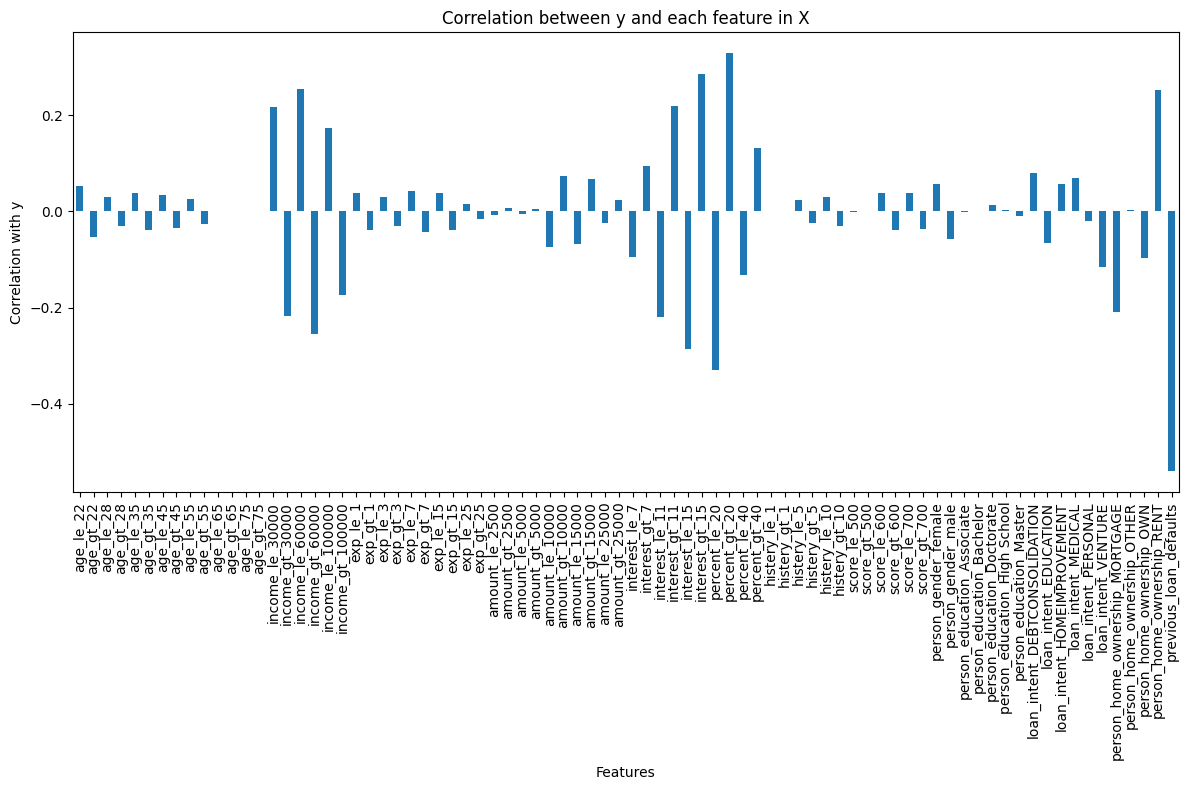

In [28]:
correlations = X_binarized.corrwith(y)
correlations.plot(kind='bar', figsize=(12, 8))
plt.title('Correlation between y and each feature in X')
plt.xlabel('Features')
plt.ylabel('Correlation with y')
plt.tight_layout()
plt.savefig('binarized.png')
plt.show()

## Data split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

The problem with the standard classifier lies in the uneven distribution of
classes: the number of positive classes is significantly lower than that of
negative classes, which is why a modification to the algorithm was applied.
Various experiments were conducted on the validation set, during which
different thresholds for positive classifiers were considered. The most
optimal solution turned out to be selecting the positive class on the
condition that positive classifiers make up at least 10% of the identified
negative classifiers.

In [54]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.coef = 0.1

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative classes
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_negative == 0 and num_positive > 1
        
        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_positive == 0 and num_negative > 1
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers * self.coef:
            print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1  # Predict positive
            
        elif negative_classifiers > positive_classifiers:
            print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0  # Predict negative

        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            print(f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}")
        
            return 0  # or 0, depending on the choice


    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        # List to store predictions for each test sample
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in X_test.iterrows():
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample)
            predictions.append(prediction)
        
        return predictions

In [55]:
X_train_binarized = binarize_features(X_train).astype(bool)
X_test_binarized = binarize_features(X_test).astype(bool)

In [56]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_binarized, y_train)

In [57]:
sample = X_test_binarized.iloc[-1]
y.iloc[-1]

1

In [58]:
classifier.classify_sample(sample)

sample 10385 is classified as 1, positive_classifiers=28, negative_classifiers=24


1

In [59]:
y_pred = classifier.predict(X_test_binarized)

sample 15141 is classified as 0, positive_classifiers=0, negative_classifiers=1066
sample 32050 is classified as 0, positive_classifiers=0, negative_classifiers=459
sample 33857 is classified as 1, positive_classifiers=5, negative_classifiers=46
sample 33007 is classified as 1, positive_classifiers=27, negative_classifiers=242
sample 9331 is classified as 0, positive_classifiers=0, negative_classifiers=281
sample 40843 is classified as 0, positive_classifiers=1, negative_classifiers=209
sample 28174 is classified as 0, positive_classifiers=1, negative_classifiers=1114
sample 12360 is classified as 1, positive_classifiers=20, negative_classifiers=168
sample 29925 is classified as 0, positive_classifiers=0, negative_classifiers=501
sample 35258 is classified as 0, positive_classifiers=8, negative_classifiers=1058
sample 35171 is classified as 0, positive_classifiers=20, negative_classifiers=209
sample 10808 is classified as 0, positive_classifiers=0, negative_classifiers=349
sample 35339

In [60]:
# Not modified results
classifier.coef = 1
y_pred_not_modified = classifier.predict(X_test_binarized)

sample 15141 is classified as 0, positive_classifiers=0, negative_classifiers=1066
sample 32050 is classified as 0, positive_classifiers=0, negative_classifiers=459
sample 33857 is classified as 0, positive_classifiers=5, negative_classifiers=46
sample 33007 is classified as 0, positive_classifiers=27, negative_classifiers=242
sample 9331 is classified as 0, positive_classifiers=0, negative_classifiers=281
sample 40843 is classified as 0, positive_classifiers=1, negative_classifiers=209
sample 28174 is classified as 0, positive_classifiers=1, negative_classifiers=1114
sample 12360 is classified as 0, positive_classifiers=20, negative_classifiers=168
sample 29925 is classified as 0, positive_classifiers=0, negative_classifiers=501
sample 35258 is classified as 0, positive_classifiers=8, negative_classifiers=1058
sample 35171 is classified as 0, positive_classifiers=20, negative_classifiers=209
sample 10808 is classified as 0, positive_classifiers=0, negative_classifiers=349
sample 35339

## Calculating metrics

In [61]:
def calculate_metrics(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metrics = {
        'True Positive': tp,
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Negative Rate (Specificity)': tn / (tn + fp) if (tn + fp) != 0 else 0,
        'Negative Predictive Value': tn / (tn + fn) if (tn + fn) != 0 else 0,
        'False Positive Rate': fp / (fp + tn) if (fp + tn) != 0 else 0,
        'False Discovery Rate': fp / (fp + tp) if (fp + tp) != 0 else 0,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (True Positive Rate)': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    return metrics

In [62]:
metrics = calculate_metrics(y_test, y_pred)w

# Creating DataFrame for saving results
metrics_df = pd.DataFrame(metrics, index=['Lazy_FCA'])
metrics_df

,True Positive,True Negative,False Positive,False Negative,True Negative Rate (Specificity),Negative Predictive Value,False Positive Rate,False Discovery Rate,Accuracy,Precision,Recall (True Positive Rate),F1 Score
Lazy_FCA,31,166,9,19,0.948571,0.897297,0.051429,0.225,0.875556,0.775,0.62,0.688889


In [63]:
metrics = calculate_metrics(y_test, y_pred_not_modified)
metrics_df.loc['Not modified FCA'] = metrics

## Comparative analysis

In [64]:
# Prepare features for classification
def prepare_features(df, preprocessor=None):
    # drop unsused columns
    categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent',
                            'previous_loan_defaults_on_file']
    numerical_features = ['person_age', 'person_income','person_emp_exp', 'loan_amnt', 'loan_int_rate',
                          'loan_percent_income', 'cb_person_cred_hist_length','credit_score']
    features = df[categorical_features + numerical_features]

    # preprocess
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), numerical_features),
                ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
            ]
        )
        features = preprocessor.fit_transform(df)
    else:
        features = preprocessor.transform(df)

    return features, preprocessor


X_train, preprocessor = prepare_features(X_train)
X_test, _ = prepare_features(X_test, preprocessor)

In [65]:
# Dictionary for choosing hyperparameters
param_grid = {
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'GaussianNB': {},
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 200, 300],
        'multi_class': ['auto', 'ovr', 'multinomial']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'degree': [2, 3, 4]
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.8, 1.0]
    }
}

In [66]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': xgb.XGBClassifier()
}

In [67]:
best_models = {}
ind = 0

for clf_name, clf in classifiers.items():
    ind += 1
    if clf_name not in best_models:
        print(f"Tuning hyperparameters for {clf_name}...")
    
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid[clf_name], cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_models[clf_name] = grid_search.best_estimator_
        print(f"Best hyperparameters for {clf_name}: {grid_search.best_params_}")
        
        # Training and validation
        y_pred = best_models[clf_name].predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)

        # Saving the results
        metrics_df.loc[clf_name] = metrics
        

# Combining all results into a single DataFrame
print("All metrics:")
metrics_df

Tuning hyperparameters for KNeighborsClassifier...
Best hyperparameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'distance'}
Tuning hyperparameters for GaussianNB...
Best hyperparameters for GaussianNB: {}
Tuning hyperparameters for LogisticRegression...
Best hyperparameters for LogisticRegression: {'C': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'penalty': 'l2'}
Tuning hyperparameters for SVC...
Best hyperparameters for SVC: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Tuning hyperparameters for DecisionTreeClassifier...
Best hyperparameters for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Tuning hyperparameters for RandomForestClassifier...
Best hyperparameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Tuning hyperparameters for XGBClassifier...
Best hyperparameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_we

,True Positive,True Negative,False Positive,False Negative,True Negative Rate (Specificity),Negative Predictive Value,False Positive Rate,False Discovery Rate,Accuracy,Precision,Recall (True Positive Rate),F1 Score
Lazy_FCA,31,166,9,19,0.948571,0.897297,0.051429,0.225000,0.875556,0.775000,0.62,0.688889
Not modified FCA,5,175,0,45,1.000000,0.795455,0.000000,0.000000,0.800000,1.000000,0.10,0.181818
KNeighborsClassifier,31,164,11,19,0.937143,0.896175,0.062857,0.261905,0.866667,0.738095,0.62,0.673913
GaussianNB,50,110,65,0,0.628571,1.000000,0.371429,0.565217,0.711111,0.434783,1.00,0.606061
LogisticRegression,36,167,8,14,0.954286,0.922652,0.045714,0.181818,0.902222,0.818182,0.72,0.765957
SVC,40,169,6,10,0.965714,0.944134,0.034286,0.130435,0.928889,0.869565,0.80,0.833333
DecisionTreeClassifier,38,167,8,12,0.954286,0.932961,0.045714,0.173913,0.911111,0.826087,0.76,0.791667
RandomForestClassifier,39,172,3,11,0.982857,0.939891,0.017143,0.071429,0.937778,0.928571,0.78,0.847826
XGBClassifier,41,170,5,9,0.971429,0.949721,0.028571,0.108696,0.937778,0.891304,0.82,0.854167


The Lazy FCA classification approach demonstrated competitive performance compared to traditional machine learning algorithms, achieving an accuracy of 88% and maintaining a good balance between precision (0.76) and recall (0.62).

Unlike "black box" models such as SVC or Neural Networks, Lazy FCA provides clear, concept-based explanations for its classifications
The classification process can be traced through formal concepts, making it possible to understand exactly why a particular decision was made

The results indicate that Lazy FCA achieves a reasonable trade-off between performance and interpretability, making it particularly valuable in domains where decision transparency is crucial, such as healthcare or financial applications.

In [68]:
metrics_df.to_excel('metrics.xlsx')